In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [17]:
class PerformancePlotter:
    def __init__(self, path):
        self.path = path
        self.dataframes = self.read_anotation_file()

    def read_anotation_file(self):
        path = self.path
        files = os.listdir(path)
        txt_files = [file for file in files if file.endswith('.txt')]
        dataframes = {}
        print("#####################################")
        for file in txt_files:
            # read file
            file_name = file.split('_annotations.txt')[0]
            file_path = os.path.join(path, file)
            df = pd.read_csv(file_path, sep='\t', header=None, names=['beats', 'downbeats', 'beats_type'])
            
            # get the time signature from first row, third column
            info = df.iloc[0, 2]
            split_parts = info.split(',')
            df.iloc[0, 2] = split_parts[0]
            num_b = int(split_parts[1].split('/')[0])
            
            # convert the beats type to binary
            # df['beats_type'] = df['beats_type'].map({'db': 1, 'b': 0})
            df['duration'] = df['beats'].diff()
            df['duration'].iloc[0] = df['beats'].iloc[0]
            df.drop('downbeats', axis=1, inplace=True)
            
            # add the time signature and key signature to the column name
            if file_name == 'midi_score':
                column_name = 'Unperformed'
                df['duration'].iloc[0] = 1
                df.loc[0, 'duration'] = 1
                print("The time signature is: ", split_parts[1])
            else:
                column_name = file_name + '_' + split_parts[1]
                
            df['num_bar'] = (df.index // num_b) + 1
            df['num_beat'] = (df.index % num_b) + 1
            # print(column_name)
            
            # Add the dataframe to the dictionary
            dataframes[column_name] = df
        print("Finished reading txt files")
        for key in dataframes:
            dataframes[key]['ratio'] = dataframes[key]['duration'] / dataframes['Unperformed']['duration']
        return dataframes

    def plot_ratio(self):
        print("#####################################")
        print("Plotting the ratio of the whole piece")
        for key in self.dataframes:
            plt.plot(self.dataframes[key]['ratio'], label=key)
        plt.xlabel('time')
        plt.ylabel('ratio')
        plt.legend()
        plt.show()
    
    def calculate_means(self):
        means = {}
        for key in self.dataframes:
            means[key] = self.dataframes[key].groupby('num_beat')['ratio'].mean()
        means = pd.DataFrame(means)
        performed = [col for col in means.columns if col != 'Unperformed']
        means['average'] = means[performed].mean(axis=1)
        return means

    def plot_bar(self, means):
        print("#####################################")
        print("Plotting the timing mapping of one bar")
        for key in means:
            plt.plot(means[key], label=key)
        
        plt.xlabel('beat')
        plt.ylabel('ratio')
        plt.legend()
        xticks = means.index
        plt.xticks(xticks)
        plt.show()


    def run(self):
        self.plot_ratio()
        means = self.calculate_means()
        self.plot_bar(means)


#####################################
The time signature is:  6/8
Finished reading txt files
#####################################
Plotting the ratio of the whole piece


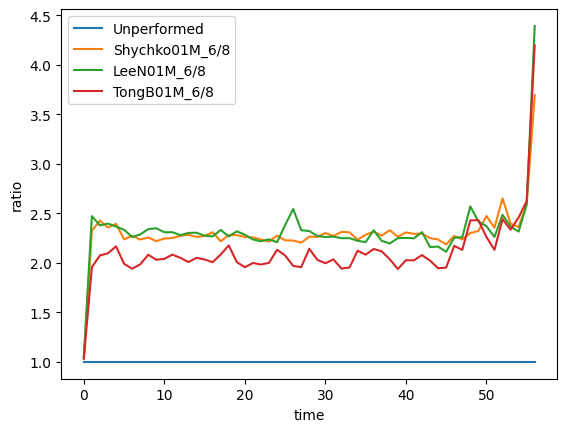

#####################################
Plotting the mapping of one bar


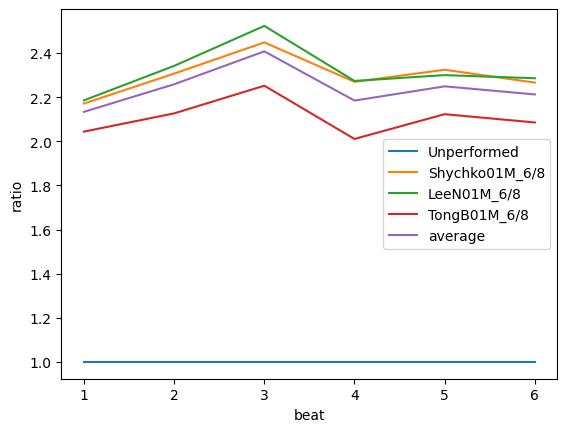

In [21]:
plotter = PerformancePlotter('./Bach/Prelude/bwv_863')
plotter.run()